In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTENC
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
from keras.optimizers import *

# Utilitas
import os
from google.colab import drive
from google.colab import files

# Data

In [2]:
drive.mount('/content/drive')
googleDrivePath = "/content/drive/MyDrive/Colab_Notebooks/Dataset/"

Mounted at /content/drive


In [3]:
data_train = pd.read_csv(googleDrivePath + "train_data_ESI_with_robust_scaler.csv")
data_test = pd.read_csv(googleDrivePath + "test_data_ESI_with_robust_scaler.csv")

In [4]:
frames = [data_train, data_test]

df = pd.concat(frames)

In [5]:
df.sample(5)

,age,triage_vital_hr,triage_vital_sbp,triage_vital_dbp,triage_vital_rr,triage_vital_o2,triage_vital_temp,gender_Male,triage_vital_o2_device_1.0,cc_abdominalcramping_1.0,...,cc_woundcheck_1.0,cc_woundinfection_1.0,cc_woundre-evaluation_1.0,cc_wristinjury_1.0,cc_wristpain_1.0,class_0,class_1,class_2,class_3,class_4
46879,-0.719038,0.363636,-0.860708,-0.751318,0.000000,0.000000,0.406324,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0
119817,1.214249,0.064885,0.325982,0.821883,-0.198474,0.267175,-0.721627,1,0,0,...,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
116081,1.500000,-0.681818,-0.148148,-0.944444,-1.000000,0.333333,-0.800000,1,0,0,...,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0
254249,-0.612419,-0.045581,0.185185,0.111111,0.000000,-0.333333,0.050046,1,0,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0
354184,-0.433333,-1.045455,-0.148148,0.055556,-1.000000,0.000000,-0.800000,1,0,0,...,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0


In [6]:
X = df.drop(columns=['class_0', 'class_1', 'class_2', 'class_3', 'class_4'])
y = df[['class_0', 'class_1', 'class_2', 'class_3', 'class_4']].values

In [7]:
like_num = [col for col in df.columns if df[col].dtypes != 'O' and len(df[col].value_counts()) > 10]
cols_need_scale = [col for col in df.columns if col not in like_num
                   and col not in 'esi']

print('like_num: ', like_num)
print("cols_need_scale: ", cols_need_scale)

like_num:  ['age', 'triage_vital_hr', 'triage_vital_sbp', 'triage_vital_dbp', 'triage_vital_rr', 'triage_vital_o2', 'triage_vital_temp']
cols_need_scale:  ['gender_Male', 'triage_vital_o2_device_1.0', 'cc_abdominalcramping_1.0', 'cc_abdominaldistention_1.0', 'cc_abdominalpain_1.0', 'cc_abdominalpainpregnant_1.0', 'cc_abnormallab_1.0', 'cc_abscess_1.0', 'cc_addictionproblem_1.0', 'cc_agitation_1.0', 'cc_alcoholintoxication_1.0', 'cc_alcoholproblem_1.0', 'cc_allergicreaction_1.0', 'cc_alteredmentalstatus_1.0', 'cc_animalbite_1.0', 'cc_ankleinjury_1.0', 'cc_anklepain_1.0', 'cc_anxiety_1.0', 'cc_arminjury_1.0', 'cc_armpain_1.0', 'cc_armswelling_1.0', 'cc_assaultvictim_1.0', 'cc_asthma_1.0', 'cc_backpain_1.0', 'cc_bleeding/bruising_1.0', 'cc_blurredvision_1.0', 'cc_bodyfluidexposure_1.0', 'cc_breastpain_1.0', 'cc_breathingdifficulty_1.0', 'cc_breathingproblem_1.0', 'cc_burn_1.0', 'cc_cardiacarrest_1.0', 'cc_cellulitis_1.0', 'cc_chestpain_1.0', 'cc_chesttightness_1.0', 'cc_chills_1.0', 'cc_c

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state = 357)

In [9]:
print("X_train Input:")
print(X_train.shape)

print("\ny_train Target:")
print(y_train.shape)

print("X_test Input:")
print(X_test.shape)

print("\ny_test Target:")
print(y_test.shape)

X_train Input:
(457834, 209)

y_train Target:
(457834, 5)
X_test Input:
(50871, 209)

y_test Target:
(50871, 5)


# Model SR-1D-CNN

In [10]:
def create_model(input_shape=(X_train.shape[1],), output_classes=5):
    # Input 1@1x209
    inputs = Input(shape=input_shape)

    # Hidden units 1024
    x = Dense(1024, activation='relu')(inputs)

    # Reshape layer 64@1x16 (Feature maps)
    x = Reshape((16, 64))(x)

    # Conv layer | 1x7 kernel 128@1x16 - (Feature maps)
    x = Conv1D(128, kernel_size=7, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Average Pooling layer | 128@1x8 - (Feature maps)
    x = AveragePooling1D(pool_size=2)(x)

    # Conv layer 2 | 1x5 kernel 64@1x8 - (Feature maps)
    x = Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Conv layer 3 | 1x5 kernel 64@1x8 - (Feature maps)
    x = Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Element-wise addition
    skip_connection = x

    # Conv layer 4 | 1x3 kernel 64@1x8 - (Feature maps)
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Add()([x, skip_connection])

    # Average Pooling layer
    x = AveragePooling1D(pool_size=2)(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layer
    x = Dense(256, activation='relu')(x)

    # Dropout layer
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(output_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

model = create_model()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 209)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 1024)                 215040    ['input_1[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 16, 64)               0         ['dense[0][0]']               
                                                                                                  
 conv1d (Conv1D)             (None, 16, 128)              57472     ['reshape[0][0]']             
                                                                                              

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Total epochs
total_epochs = 20

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Latih model dengan callback EarlyStopping
history = model.fit(
    X_train,
    y_train,
    epochs=total_epochs,
    batch_size=1024,
    validation_split=0.10,
    callbacks=[early_stopping]
)

Epoch 1/20
403/403 [==============================] - 17s 16ms/step - loss: 0.6699 - accuracy: 0.7338 - auc: 0.9422 - val_loss: 2.2298 - val_accuracy: 0.3969 - val_auc: 0.6879 - lr: 0.0010
Epoch 2/20
403/403 [==============================] - 6s 15ms/step - loss: 0.5941 - accuracy: 0.7633 - auc: 0.9535 - val_loss: 0.5877 - val_accuracy: 0.7615 - val_auc: 0.9544 - lr: 0.0019
Epoch 3/20
403/403 [==============================] - 5s 13ms/step - loss: 0.5784 - accuracy: 0.7684 - auc: 0.9558 - val_loss: 0.5667 - val_accuracy: 0.7691 - val_auc: 0.9574 - lr: 0.0028
Epoch 4/20
403/403 [==============================] - 5s 13ms/step - loss: 0.5683 - accuracy: 0.7724 - auc: 0.9572 - val_loss: 0.5687 - val_accuracy: 0.7707 - val_auc: 0.9571 - lr: 0.0037
Epoch 5/20
403/403 [==============================] - 6s 14ms/step - loss: 0.5569 - accuracy: 0.7767 - auc: 0.9588 - val_loss: 0.5777 - val_accuracy: 0.7628 - val_auc: 0.9556 - lr: 0.0046
Epoch 6/20
403/403 [==============================] - 5s 13

In [12]:
label_kelas = ['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']

# Prediksi dengan model
y_pred_probs = model.predict(X_test, batch_size=1024)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Konversi y_test ke bentuk yang sama dengan y_pred_classes
y_test_classes = np.argmax(y_test, axis=1)

50/50 [==============================] - 1s 9ms/step


In [13]:
# Evaluasi model dengan data uji
results = model.evaluate(X_test, y_test, batch_size=1024, return_dict=True)

# Ambil nilai akurasi dan AUC dari hasil evaluasi
accuracy = results['accuracy']
model_auc = results['auc']

# Tampilkan hasil evaluasi
print(f"Accuracy: {accuracy}")
print(f"AUC: {model_auc}")

50/50 [==============================] - 0s 5ms/step - loss: 0.6189 - accuracy: 0.8130 - auc: 0.9604
Accuracy: 0.8130172491073608
AUC: 0.9603831171989441


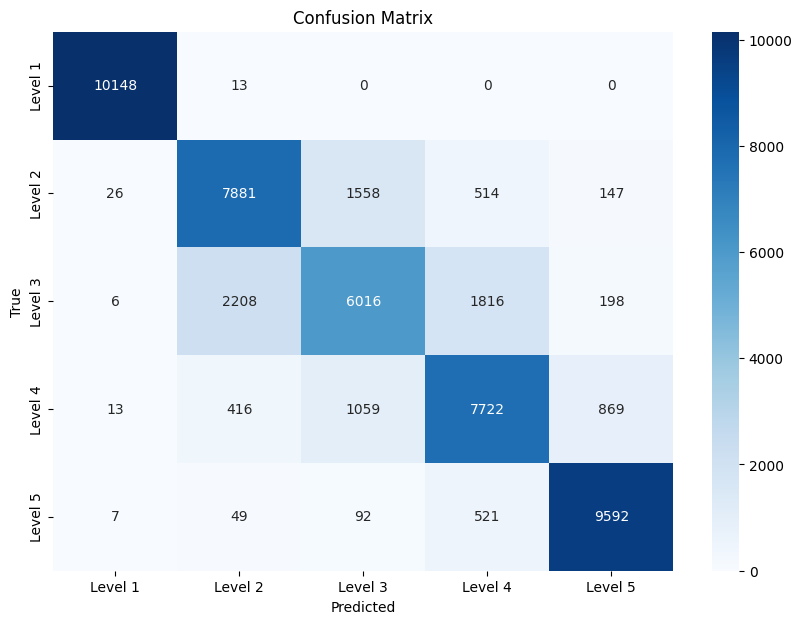

In [14]:
  # Buat confusion matrix
  conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

  # Plot confusion matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_kelas, yticklabels=label_kelas)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

In [15]:
# Buat dan tampilkan laporan klasifikasi
report = classification_report(y_test_classes, y_pred_classes, target_names=label_kelas)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Level 1       0.99      1.00      1.00     10161
     Level 2       0.75      0.78      0.76     10126
     Level 3       0.69      0.59      0.63     10244
     Level 4       0.73      0.77      0.75     10079
     Level 5       0.89      0.93      0.91     10261

    accuracy                           0.81     50871
   macro avg       0.81      0.81      0.81     50871
weighted avg       0.81      0.81      0.81     50871



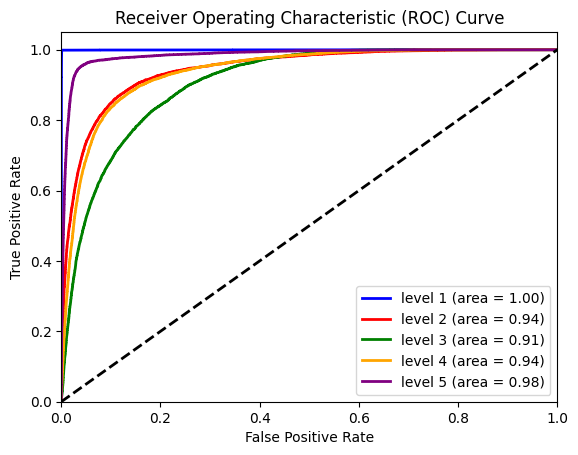

In [16]:
# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='level {0} (area = {1:0.2f})'
             ''.format(i + 1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# DNN

In [22]:
def create_dense_model(input_shape=(209,), output_classes=5):
    # Input layer
    inputs = Input(shape=input_shape)

    # Hidden layer 1
    x = Dense(1024, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Hidden layer 4
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(output_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Creating the model
model_dense = create_dense_model()
model_dense.summary()

# Compiling the model_dense
model_dense.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 209)]             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              215040    
                                                                 
 batch_normalization_4 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                          

In [23]:
# Latih model dengan callback EarlyStopping
history_dense = model_dense.fit(
    X_train,
    y_train,
    epochs=total_epochs,
    batch_size=1024,
    validation_split=0.10,
    # callbacks=[early_stopping]
    callbacks=[lr_schedule, early_stopping]
)

Epoch 1/20
403/403 [==============================] - 5s 8ms/step - loss: 0.8413 - accuracy: 0.6743 - auc: 0.9124 - val_loss: 0.8637 - val_accuracy: 0.7038 - val_auc: 0.9267 - lr: 0.0010
Epoch 2/20
403/403 [==============================] - 3s 7ms/step - loss: 0.6851 - accuracy: 0.7287 - auc: 0.9394 - val_loss: 0.6249 - val_accuracy: 0.7488 - val_auc: 0.9489 - lr: 0.0019
Epoch 3/20
403/403 [==============================] - 4s 10ms/step - loss: 0.6583 - accuracy: 0.7384 - auc: 0.9436 - val_loss: 0.6131 - val_accuracy: 0.7527 - val_auc: 0.9505 - lr: 0.0028
Epoch 4/20
403/403 [==============================] - 3s 7ms/step - loss: 0.6448 - accuracy: 0.7434 - auc: 0.9457 - val_loss: 0.6029 - val_accuracy: 0.7544 - val_auc: 0.9521 - lr: 0.0037
Epoch 5/20
403/403 [==============================] - 3s 7ms/step - loss: 0.6351 - accuracy: 0.7470 - auc: 0.9472 - val_loss: 0.5949 - val_accuracy: 0.7594 - val_auc: 0.9533 - lr: 0.0046
Epoch 6/20
403/403 [==============================] - 3s 6ms/ste

In [24]:
label_kelas = ['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']

# Prediksi dengan model
y_pred_probs = model_dense.predict(X_test, batch_size=1024)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Konversi y_test ke bentuk yang sama dengan y_pred_classes
y_test_classes = np.argmax(y_test, axis=1)

50/50 [==============================] - 0s 3ms/step


In [25]:
# Evaluasi model dengan data uji
results = model_dense.evaluate(X_test, y_test, batch_size=1024, return_dict=True)

# Ambil nilai akurasi dan AUC dari hasil evaluasi
accuracy = results['accuracy']
model_auc = results['auc']

# Tampilkan hasil evaluasi
print(f"Accuracy: {accuracy}")
print(f"AUC: {model_auc}")

50/50 [==============================] - 0s 6ms/step - loss: 0.5495 - accuracy: 0.7759 - auc: 0.9599
Accuracy: 0.7759234309196472
AUC: 0.9599282741546631


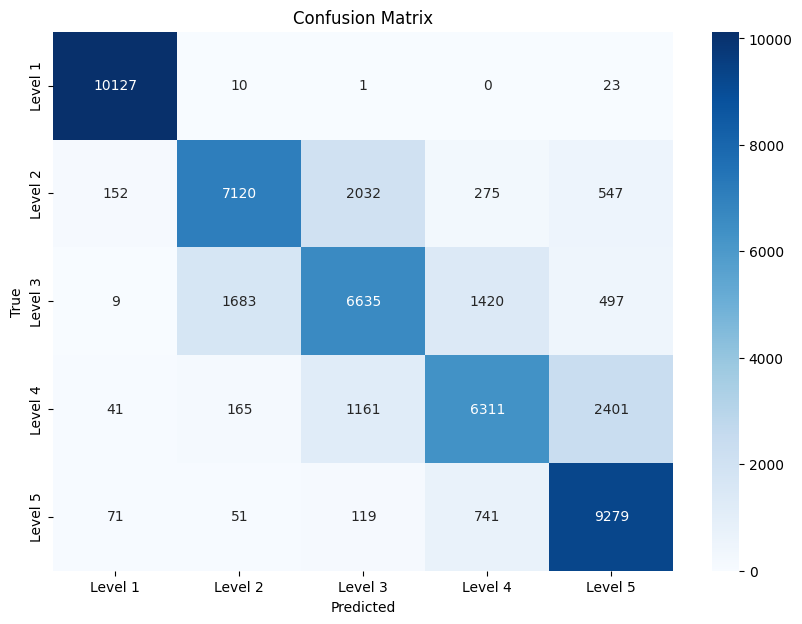

In [26]:
# Buat confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_kelas, yticklabels=label_kelas)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Buat dan tampilkan laporan klasifikasi
report = classification_report(y_test_classes, y_pred_classes, target_names=label_kelas)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Level 1       0.97      1.00      0.99     10161
     Level 2       0.79      0.70      0.74     10126
     Level 3       0.67      0.65      0.66     10244
     Level 4       0.72      0.63      0.67     10079
     Level 5       0.73      0.90      0.81     10261

    accuracy                           0.78     50871
   macro avg       0.78      0.78      0.77     50871
weighted avg       0.78      0.78      0.77     50871



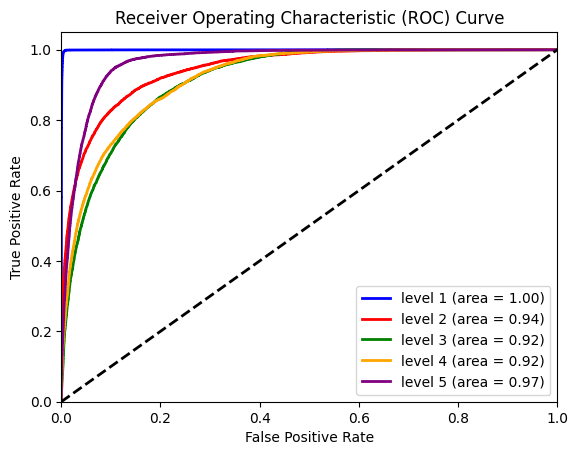

In [28]:
# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='level {0} (area = {1:0.2f})'
             ''.format(i + 1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Model Vanilla-1D-CNN

In [29]:
def create_model(input_shape=(X_train.shape[1],), output_classes=5):
    inputs = Input(shape=input_shape)

    # Expand dimensions to make the input shape (batch_size, timesteps, features)
    x = Lambda(lambda x: tf.expand_dims(x, axis=-1))(inputs)

    # Zero Padding to make the input length 240
    x = ZeroPadding1D(padding=(0, 31))(x)  # Pad to make the input length 240

    # Convolution Layer 1
    x = Conv1D(128, kernel_size=7, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)


    # Average Pooling layer
    x = AveragePooling1D(pool_size=2)(x)

    # Conv layer 2
    x = Conv1D(128, kernel_size=5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Conv layer 3
    x = Conv1D(64, kernel_size=5, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Conv layer 4
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Element-wise addition
    skip_connection = x

    # Conv layer 5
    x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Add()([x, skip_connection])

    # Average Pooling layer
    x = AveragePooling1D(pool_size=2)(x)

    # Flatten layer
    x = Flatten()(x)

    # Dense layer
    x = Dense(256, activation='relu')(x)

    # Dropout layer
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(output_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=inputs, outputs=outputs)

    return model

model = create_model()
model.summary()
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 209)]                0         []                            
                                                                                                  
 lambda (Lambda)             (None, 209, 1)               0         ['input_3[0][0]']             
                                                                                                  
 zero_padding1d (ZeroPaddin  (None, 240, 1)               0         ['lambda[0][0]']              
 g1D)                                                                                             
                                                                                                  
 conv1d_4 (Conv1D)           (None, 240, 128)             1024      ['zero_padding1d[0][0]']

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Learning rate scheduler (OneCycleLR)
def one_cycle_lr(epoch, total_epochs, max_lr, base_lr, step_size):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1 - x))
    return lr

# Total epochs
total_epochs = 20

# Step size is typically half the total number of epochs
step_size = total_epochs // 2

# Maximum learning rate
max_lr = 0.01

# Base learning rate
base_lr = 0.001

lr_schedule = LearningRateScheduler(
    lambda epoch: one_cycle_lr(epoch, total_epochs, max_lr, base_lr, step_size)
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Latih model dengan callback EarlyStopping
history = model.fit(
    X_train,
    y_train,
    epochs=total_epochs,
    batch_size=1024,
    validation_split=0.10,
    callbacks=[lr_schedule, early_stopping]
)

Epoch 1/20
403/403 [==============================] - 50s 111ms/step - loss: 0.7591 - accuracy: 0.7097 - auc: 0.9287 - val_loss: 5.1069 - val_accuracy: 0.2626 - val_auc: 0.5627 - lr: 0.0010
Epoch 2/20
403/403 [==============================] - 44s 109ms/step - loss: 0.6493 - accuracy: 0.7409 - auc: 0.9451 - val_loss: 5.8602 - val_accuracy: 0.3374 - val_auc: 0.5967 - lr: 0.0019
Epoch 3/20
403/403 [==============================] - 44s 109ms/step - loss: 0.6341 - accuracy: 0.7454 - auc: 0.9473 - val_loss: 6.6195 - val_accuracy: 0.3054 - val_auc: 0.5877 - lr: 0.0028
Epoch 4/20
403/403 [==============================] - 44s 110ms/step - loss: 0.6248 - accuracy: 0.7490 - auc: 0.9488 - val_loss: 4.1157 - val_accuracy: 0.3382 - val_auc: 0.6312 - lr: 0.0037
Epoch 5/20
403/403 [==============================] - 45s 112ms/step - loss: 0.6199 - accuracy: 0.7505 - auc: 0.9496 - val_loss: 5.2286 - val_accuracy: 0.2447 - val_auc: 0.5738 - lr: 0.0046
Epoch 6/20
403/403 [==============================

In [31]:
label_kelas = ['Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5']

# Prediksi dengan model
y_pred_probs = model.predict(X_test, batch_size=1024)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Konversi y_test ke bentuk yang sama dengan y_pred_classes
y_test_classes = np.argmax(y_test, axis=1)

50/50 [==============================] - 2s 37ms/step


In [32]:
# Evaluasi model dengan data uji
results = model.evaluate(X_test, y_test, batch_size=1024, return_dict=True)

# Ambil nilai akurasi dan AUC dari hasil evaluasi
accuracy = results['accuracy']
model_auc = results['auc']

# Tampilkan hasil evaluasi
print(f"Accuracy: {accuracy}")
print(f"AUC: {model_auc}")

50/50 [==============================] - 2s 31ms/step - loss: 0.6341 - accuracy: 0.7457 - auc: 0.9482
Accuracy: 0.7456704378128052
AUC: 0.9482462406158447


In [33]:
# Buat dan tampilkan laporan klasifikasi
report = classification_report(y_test_classes, y_pred_classes, target_names=label_kelas, zero_division=0)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Level 1       0.98      0.98      0.98     10161
     Level 2       0.83      0.61      0.70     10126
     Level 3       0.56      0.72      0.63     10244
     Level 4       0.66      0.64      0.65     10079
     Level 5       0.77      0.78      0.77     10261

    accuracy                           0.75     50871
   macro avg       0.76      0.75      0.75     50871
weighted avg       0.76      0.75      0.75     50871



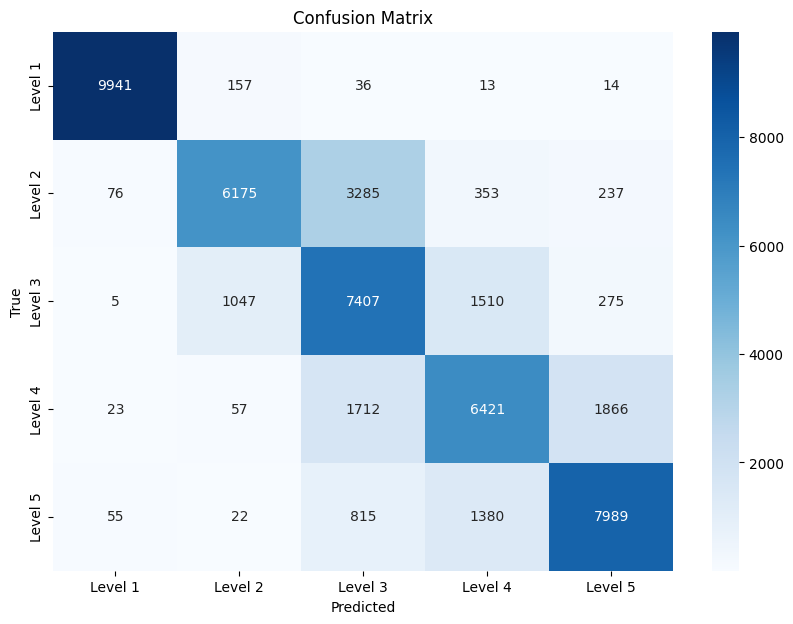

In [34]:
# Buat confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_kelas, yticklabels=label_kelas)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

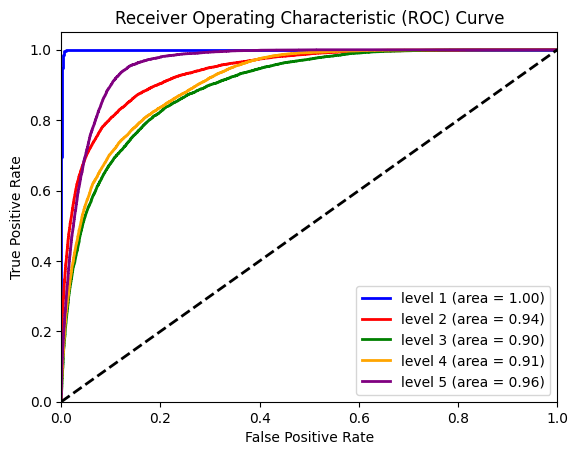

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='level {0} (area = {1:0.2f})'
             ''.format(i + 1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Save utility

In [17]:
# saved_path = "/content/"

In [18]:
# y_train_df = pd.DataFrame(y_train, columns=['class_0', 'class_1', 'class_2', 'class_3', 'class_4'])
# train_df = pd.concat([X_train.reset_index(drop=True), y_train_df.reset_index(drop=True)], axis=1)
# train_df.to_csv(saved_path + 'dataset_train_SR_CNN.csv', index=False)

In [19]:
# y_test_df = pd.DataFrame(y_test, columns=['class_0', 'class_1', 'class_2', 'class_3', 'class_4'])
# test_df = pd.concat([X_test.reset_index(drop=True), y_test_df.reset_index(drop=True)], axis=1)
# test_df.to_csv(saved_path + 'dataset_test_SR_CNN.csv', index=False)

In [20]:
# model.save(saved_path + 'model_ESI_SR_CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# import joblib

# joblib.dump(label_encoder, saved_path + 'label_encoder_ESI.pkl')
# joblib.dump(robustScaler, saved_path + 'robust_scaler_ESI.pkl')